In [69]:
import pandas as pd
import itertools
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from wordcloud import WordCloud

In [70]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [71]:
path = "/content/drive/MyDrive/Colab Notebooks/malicious_phish.csv"
df = pd.read_csv(path)
print(df)

                                                      url        type
0                                        br-icloud.com.br    phishing
1                     mp3raid.com/music/krizz_kaliko.html      benign
2                         bopsecrets.org/rexroth/cr/1.htm      benign
3       http://www.garage-pirenne.be/index.php?option=...  defacement
4       http://adventure-nicaragua.net/index.php?optio...  defacement
...                                                   ...         ...
651186            xbox360.ign.com/objects/850/850402.html    phishing
651187       games.teamxbox.com/xbox-360/1860/Dead-Space/    phishing
651188         www.gamespot.com/xbox360/action/deadspace/    phishing
651189      en.wikipedia.org/wiki/Dead_Space_(video_game)    phishing
651190          www.angelfire.com/goth/devilmaycrytonite/    phishing

[651191 rows x 2 columns]


In [72]:
# Number of rows to drop
n = 628103
 
# Slicing last n rows
df = df[:-n]

In [73]:
df.type.value_counts()

benign        16961
defacement     4220
phishing       1338
malware         569
Name: type, dtype: int64

In [74]:
df.isnull().values.any()

False

In [75]:
df_phish = df[df.type=='phishing']
df_malware = df[df.type=='malware']
df_deface = df[df.type=='defacement']
df_benign = df[df.type=='benign']

In [76]:
###Feature Engineering

In [77]:
import re
#Use of IP or not in domain
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0
df['use_of_ip'] = df['url'].apply(lambda i: having_ip_address(i))

In [78]:
from urllib.parse import urlparse

def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0


df['abnormal_url'] = df['url'].apply(lambda i: abnormal_url(i))

In [79]:
#!pip install googlesearch-python
!pip install googlesearch-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [80]:
from googlesearch import search

def google_index(url):
    site = search(url, 5)
    return 1 if site else 0
df['google_index'] = df['url'].apply(lambda i: google_index(i))

In [81]:
def count_dot(url):
    count_dot = url.count('.')
    return count_dot

df['count.'] = df['url'].apply(lambda i: count_dot(i))
df.head()

,url,type,use_of_ip,abnormal_url,google_index,count.
0,br-icloud.com.br,phishing,0,0,1,2
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,1,2
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,1,2
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,1,3
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,1,2


In [82]:
def count_www(url):
    url.count('www')
    return url.count('www')

df['count-www'] = df['url'].apply(lambda i: count_www(i))

def count_atrate(url):
     
    return url.count('@')

df['count@'] = df['url'].apply(lambda i: count_atrate(i))


def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')

df['count_dir'] = df['url'].apply(lambda i: no_of_dir(i))

def no_of_embed(url):
    urldir = urlparse(url).path
    return urldir.count('//')

df['count_embed_domian'] = df['url'].apply(lambda i: no_of_embed(i))


def shortening_service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0
    
    
df['short_url'] = df['url'].apply(lambda i: shortening_service(i))

In [83]:
def count_https(url):
    return url.count('https')

df['count-https'] = df['url'].apply(lambda i : count_https(i))

def count_http(url):
    return url.count('http')

df['count-http'] = df['url'].apply(lambda i : count_http(i))

In [84]:
def count_per(url):
    return url.count('%')

df['count%'] = df['url'].apply(lambda i : count_per(i))

def count_ques(url):
    return url.count('?')

df['count?'] = df['url'].apply(lambda i: count_ques(i))

def count_hyphen(url):
    return url.count('-')

df['count-'] = df['url'].apply(lambda i: count_hyphen(i))

def count_equal(url):
    return url.count('=')

df['count='] = df['url'].apply(lambda i: count_equal(i))

def url_length(url):
    return len(str(url))


#Length of URL
df['url_length'] = df['url'].apply(lambda i: url_length(i))
#Hostname Length

def hostname_length(url):
    return len(urlparse(url).netloc)

df['hostname_length'] = df['url'].apply(lambda i: hostname_length(i))

df.head()

def suspicious_words(url):
    match = re.search('PayPal|login|signin|bank|account|update|free|lucky|service|bonus|ebayisapi|webscr',
                      url)
    if match:
        return 1
    else:
        return 0
df['sus_url'] = df['url'].apply(lambda i: suspicious_words(i))


def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits


df['count-digits']= df['url'].apply(lambda i: digit_count(i))


def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters


df['count-letters']= df['url'].apply(lambda i: letter_count(i))

df.head()

,url,type,use_of_ip,abnormal_url,google_index,count.,count-www,count@,count_dir,count_embed_domian,...,count-http,count%,count?,count-,count=,url_length,hostname_length,sus_url,count-digits,count-letters
0,br-icloud.com.br,phishing,0,0,1,2,0,0,0,0,...,0,0,0,1,0,16,0,0,0,13
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,1,2,0,0,2,0,...,0,0,0,0,0,35,0,0,1,29
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,1,2,0,0,3,0,...,0,0,0,0,0,31,0,0,1,25
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,1,3,1,0,1,0,...,1,0,1,1,4,88,21,0,7,63
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,1,2,0,0,1,0,...,1,0,1,1,3,235,23,0,22,199


In [85]:
#!pip install tld
!pip install tld

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [86]:
#Importing dependencies
from urllib.parse import urlparse
from tld import get_tld
import os.path

#First Directory Length
def fd_length(url):
    urlpath= urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0

df['fd_length'] = df['url'].apply(lambda i: fd_length(i))

#Length of Top Level Domain
df['tld'] = df['url'].apply(lambda i: get_tld(i,fail_silently=True))


def tld_length(tld):
    try:
        return len(tld)
    except:
        return -1

df['tld_length'] = df['tld'].apply(lambda i: tld_length(i))

In [87]:
df = df.drop("tld",1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [88]:
df.columns

Index(['url', 'type', 'use_of_ip', 'abnormal_url', 'google_index', 'count.',
       'count-www', 'count@', 'count_dir', 'count_embed_domian', 'short_url',
       'count-https', 'count-http', 'count%', 'count?', 'count-', 'count=',
       'url_length', 'hostname_length', 'sus_url', 'count-digits',
       'count-letters', 'fd_length', 'tld_length'],
      dtype='object')

In [89]:
df['type'].value_counts()

benign        16961
defacement     4220
phishing       1338
malware         569
Name: type, dtype: int64

In [90]:
#### Target Encoding 

from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
df["type_code"] = lb_make.fit_transform(df["type"])
df["type_code"].value_counts()

0    16961
1     4220
3     1338
2      569
Name: type_code, dtype: int64

In [91]:
### Creation of Feature & Target

In [92]:
#Predictor Variables
# filtering out google_index as it has only 1 value
X = df[['use_of_ip','abnormal_url', 'count.', 'count-www', 'count@',
       'count_dir', 'count_embed_domian', 'short_url', 'count-https',
       'count-http', 'count%', 'count?', 'count-', 'count=', 'url_length',
       'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count-digits',
       'count-letters']]

#Target Variable
y = df['type_code']

In [93]:
X.head()

,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,short_url,count-https,count-http,...,count?,count-,count=,url_length,hostname_length,sus_url,fd_length,tld_length,count-digits,count-letters
0,0,0,2,0,0,0,0,0,0,0,...,0,1,0,16,0,0,0,-1,0,13
1,0,0,2,0,0,2,0,0,0,0,...,0,0,0,35,0,0,5,-1,1,29
2,0,0,2,0,0,3,0,0,0,0,...,0,0,0,31,0,0,7,-1,1,25
3,0,1,3,1,0,1,0,0,0,1,...,1,1,4,88,21,0,9,2,7,63
4,0,1,2,0,0,1,0,0,0,1,...,1,1,3,235,23,0,9,3,22,199


In [94]:
X.columns

Index(['use_of_ip', 'abnormal_url', 'count.', 'count-www', 'count@',
       'count_dir', 'count_embed_domian', 'short_url', 'count-https',
       'count-http', 'count%', 'count?', 'count-', 'count=', 'url_length',
       'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count-digits',
       'count-letters'],
      dtype='object')

In [95]:
####   Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2,shuffle=True, random_state=5)

In [96]:
#### Model Building  
X_test.head()

,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,short_url,count-https,count-http,...,count?,count-,count=,url_length,hostname_length,sus_url,fd_length,tld_length,count-digits,count-letters
22806,0,1,1,0,0,3,0,0,0,1,...,0,8,0,102,13,0,8,2,9,78
22407,0,0,2,0,0,3,0,0,0,0,...,0,0,0,46,0,0,4,-1,5,36
19461,0,0,2,0,0,2,0,0,0,0,...,0,0,0,36,0,0,2,-1,0,32
234,0,0,1,0,0,0,0,0,0,0,...,0,0,0,13,0,0,0,-1,0,12
14194,0,0,1,0,0,0,0,0,0,0,...,0,1,0,18,0,0,0,-1,0,16


In [97]:
#### 1. Random Forest Classifier  (learn the pattern ... ** rf.predict(X_test) **)

In [98]:
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
rf = RandomForestClassifier(n_estimators=100,max_features='sqrt')
rf.fit(X_train,y_train)
y_pred_rf = rf.predict(X_test)
print(classification_report(y_test,y_pred_rf,target_names=['benign', 'defacement','phishing','malware']))

score = metrics.accuracy_score(y_test, y_pred_rf)
print("accuracy:   %0.3f" % score)

              precision    recall  f1-score   support

      benign       0.99      1.00      1.00      3392
  defacement       0.96      0.98      0.97       844
    phishing       0.92      0.75      0.83       114
     malware       0.94      0.88      0.91       268

    accuracy                           0.98      4618
   macro avg       0.95      0.91      0.93      4618
weighted avg       0.98      0.98      0.98      4618

accuracy:   0.984


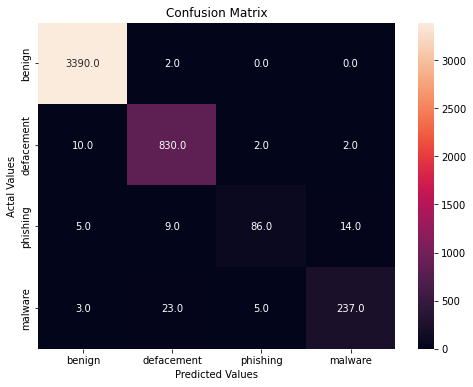

In [99]:
cm = confusion_matrix(y_test, y_pred_rf)
cm_df = pd.DataFrame(cm,
                     index = ['benign', 'defacement','phishing','malware'], 
                     columns = ['benign', 'defacement','phishing','malware'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

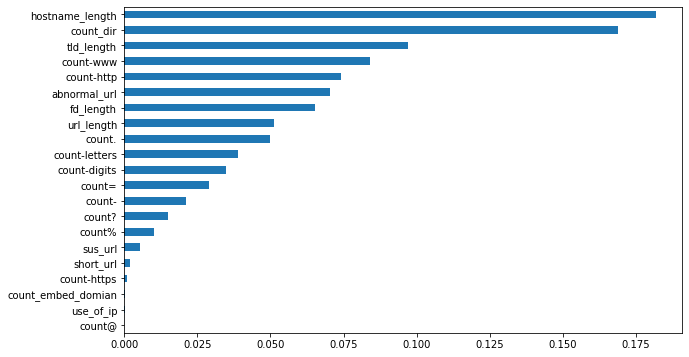

In [100]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind="barh",figsize=(10, 6))

In [101]:
## Try new one Start Exprement 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(X_train)

In [102]:

x_tr_scaled = scaler.transform(X_train)
x_ts_scaled = scaler.transform(X_test);

In [103]:
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import mae
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.activations import sigmoid, relu



In [104]:
class stopLearn(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('val_loss') < 21:
      print("\nSopt traing!!!")
      self.model.stop_trainig = True

cb = stopLearn()
model = Sequential()
model.add(Dense(units=32, kernel_initializer="normal", input_dim=x_tr_scaled.shape[1], activation=relu))
model.add(Dense(units=16, activation=relu))
model.add(Dense(units=1, activation=sigmoid))

model.compile(optimizer=Adam(learning_rate=0.001), loss=mae)

model.summary()


Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_68 (Dense)            (None, 32)                704       
                                                                 
 dense_69 (Dense)            (None, 16)                528       
                                                                 
 dense_70 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,249
Trainable params: 1,249
Non-trainable params: 0
_________________________________________________________________


In [105]:
model.fit(x=x_tr_scaled, y=y_train, validation_data=(x_ts_scaled, y_test), batch_size=10, epochs=5, callbacks=[cb])

Epoch 1/5
   1/1847 [..............................] - ETA: 14:17 - loss: 0.5001

1847/1847 [==============================] - ETA: 0s - loss: 0.2435
Sopt traing!!!
1847/1847 [==============================] - 5s 3ms/step - loss: 0.2435 - val_loss: 0.2174
Epoch 2/5
1832/1847 [============================>.] - ETA: 0s - loss: 0.2099
Sopt traing!!!
1847/1847 [==============================] - 4s 2ms/step - loss: 0.2103 - val_loss: 0.2127
Epoch 3/5
1831/1847 [============================>.] - ETA: 0s - loss: 0.2095
Sopt traing!!!
1847/1847 [==============================] - 7s 4ms/step - loss: 0.2092 - val_loss: 0.2114
Epoch 4/5
1841/1847 [============================>.] - ETA: 0s - loss: 0.2085
Sopt traing!!!
1847/1847 [==============================] - 7s 4ms/step - loss: 0.2086 - val_loss: 0.2105
Epoch 5/5
1836/1847 [============================>.] - ETA: 0s - loss: 0.2083
Sopt traing!!!
1847/1847 [==============================] - 8s 4ms/step - loss: 0.2083 - val_loss: 0.2116


<Figure size 720x432 with 0 Axes>

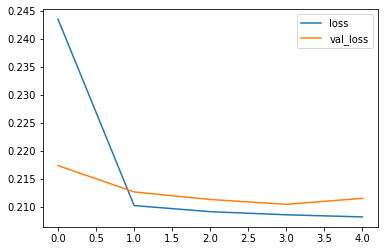

In [106]:
plt.figure(figsize=(10,6))
pd.DataFrame(model.history.history).plot()
plt.show()

In [107]:
dnn_pred = model.predict(x_ts_scaled).reshape(x_ts_scaled.shape[0], )



145/145 [==============================] - 0s 2ms/step


In [108]:
#### Deep Neural Network

DNN = Sequential()
DNN.add(Dense(2, input_dim=21, activation='relu'))
# model.add(Dropout(.2))
DNN.add(Dense(2, activation='relu'))
# model.add(Dropout(.2))
DNN.add(Dense(1, activation='sigmoid'))
   
DNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
DNN.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
_, accuracy = DNN.evaluate(X_test, y_test)
   
print(accuracy*100)

145/145 [==============================] - 0s 1ms/step - loss: -67.1296 - accuracy: 0.8584
85.83802580833435


In [109]:
!pip install tensorflow scikeras scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [110]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

In [111]:
### Deep Neural Network for Ensambling
# https://stackoverflow.com/questions/60350049/tensorflow-fit-gives-typeerror-cannot-clone-object-error
# https://machinelearningmastery.com/use-keras-deep-learning-models-scikit-learn-python/

def getModel():
    Dnn = Sequential()
    Dnn.add(Dense(6, input_dim=21, activation='relu'))
    Dnn.add(Dense(1, activation='sigmoid'))
    Dnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return Dnn
##  'RMSprop', 'Adagrad', 'Adadelta', 'Adamax', 'Nadam'
optimizer = ['SGD', 'Adam']
epochs = [1, 5]

param_grid = dict(epochs=epochs, optimizer=optimizer)
Kmodel = KerasClassifier(model=getModel, epochs=5, batch_size=10, verbose=0)

In [112]:
print(Kmodel.get_params().keys())

dict_keys(['model', 'build_fn', 'warm_start', 'random_state', 'optimizer', 'loss', 'metrics', 'batch_size', 'validation_batch_size', 'verbose', 'callbacks', 'validation_split', 'shuffle', 'run_eagerly', 'epochs', 'class_weight'])


In [113]:
# grid search epochs, batch size and optimizer
# optimizers = ['rmsprop', 'adam']
# epochs = [5]
batches = [5]
param_grid = dict(optimizer=optimizer, epochs=epochs, batch_size= batches)
grid = GridSearchCV(estimator=Kmodel, param_grid=param_grid)
grid_result = grid.fit(X_train, y_train)

In [114]:
print(grid)

GridSearchCV(estimator=KerasClassifier(batch_size=10, epochs=5, model=<function getModel at 0x7f06712ed950>, verbose=0),
             param_grid={'batch_size': [5], 'epochs': [1, 5],
                         'optimizer': ['SGD', 'Adam']})


In [117]:
grid_prid = grid_result.predict(X_test)
print("Accuracy", round(accuracy_score(y_test, grid_prid), 2))

Accuracy 0.73


In [133]:
from sklearn.model_selection import cross_val_score


In [134]:
estimators = [('RF',rf),('DNN',grid)]

In [137]:
for estimator in estimators:
    x = cross_val_score(estimator[1],X_train,y_train,cv=2,scoring='accuracy')
    print(estimator[0],np.round(np.mean(x),2))

rf 0.98
grid 0.73


In [138]:
from sklearn.ensemble import VotingClassifier

In [140]:
ensemble  = VotingClassifier(estimators=estimators,voting='hard')
x = cross_val_score(ensemble,X_train,y_train,cv=2,scoring='accuracy')
print(np.round(np.mean(x),2))

0.73


In [142]:
ensemble.fit(X_train, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_features='sqrt')),
                             ('grid',
                              GridSearchCV(estimator=KerasClassifier(batch_size=10, epochs=5, model=<function getModel at 0x7f06712ed950>, verbose=0),
                                           param_grid={'batch_size': [5],
                                                       'epochs': [1, 5],
                                                       'optimizer': ['SGD',
                                                                     'Adam']}))])

In [147]:
ens_pred = ensemble.predict(X_test)
print("Accuracy", round(accuracy_score(y_test, ens_pred), 2))

Accuracy 0.73


In [146]:
### Get pickle model ==> After train we get the model and save it for letter on use it
import pickle

with open('model_pickleDNN', 'wb') as f:
  pickle.dump(ens_pred, f)

In [ ]:
with open('model_pickle', 'rb') as f:
  MODEL = pickle.load(f)